# Logistische Gleichung

Die logistische Gleichung ist definiert als $$x_{n+1} = r \cdot x_n \cdot (1 - x_n)$$

Dadurch ist sie eine quadratische Rekursion, die von sich aus nicht sehr komplex ist. Trotzdem zeigen sich bei ihr einige Muster, die eine unerwartete Komplexität aufweisen.

Diese Gleichung ist nicht nur sehr interessant zu analysieren, sondern hat auch eine Bedeutung bei physikalischen Prozessen. So könnte man z.B. $x_n$ als eine Hasenpopulation in Prozent interpretieren, und $r$ als eine Kombination von umgebungsbedingten Faktoren, wie z.B. der Fortpflanzungsrate, des Wetters, oder der Sterberate. Der Faktor $(1 - x_n)$ wird dazu gebraucht um Überpopulation zu verhindern - wenn die Population nahe an ihren Maximalwert kommt, würde die Nahrung sowie der Lebensraum knapp werden, was im Modell durch den Faktor einberechnet wird.

## Fester Startwert $x_0$, variabler Vorfaktor $r$

Zuallererst werden wir, um eine Intuition für die Funktion zu entwickeln, zu einem festen Startwert $x_0$ verschiedene Werte von $r$ ausprobieren.

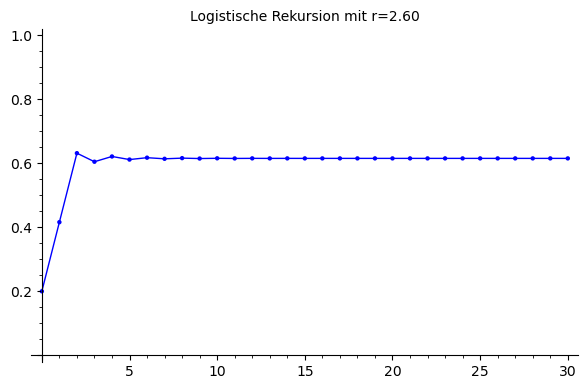

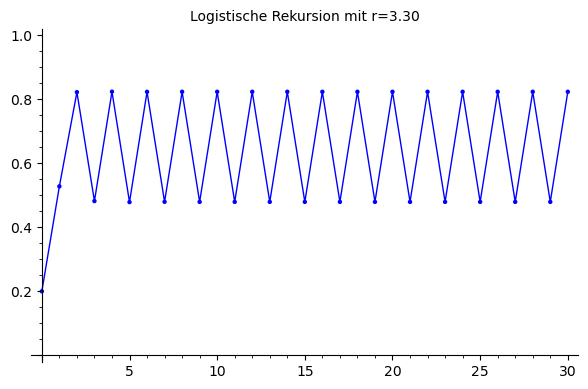

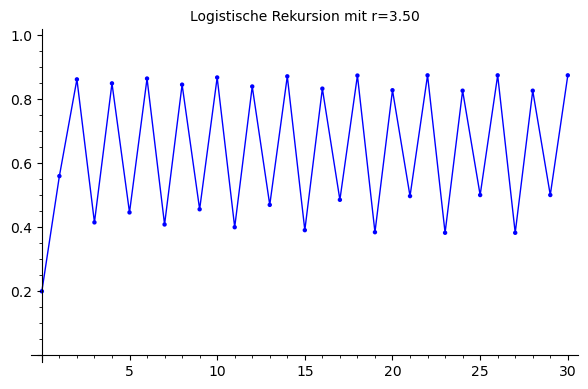

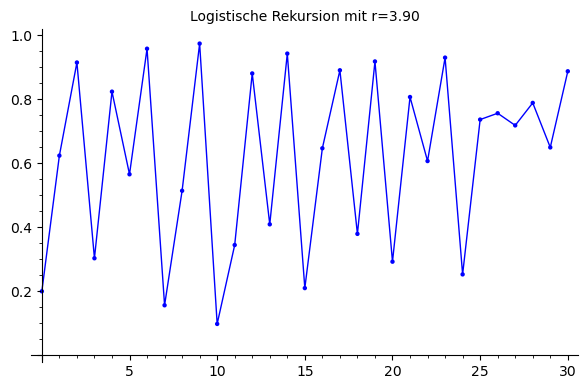

In [16]:
def logistic_map(x, r):
    return r * x * (1 - x)

def logistic_map_iter(start_x, r, num_iterations):
    x = start_x
    x_vals = [x]
    for _ in range(num_iterations):
        x = logistic_map(x, r)
        x_vals.append(x)
    
    return x_vals

def plot_logistic_map_iter(start_x, r, num_iterations=30):
    x_vals = logistic_map_iter(start_x, r, num_iterations)
    plot = line(list(enumerate(x_vals)), ymin=0, ymax=1, title=f"Logistische Rekursion mit r={r.n(digits=3)}")
    plot += points(list(enumerate(x_vals)))
    plot.show()

r_values = [2.6, 3.3, 3.5, 3.9]    

for r in r_values:
    plot_logistic_map_iter(0.2, r)

### Beobachtung

Für $r=2.6$ stabilisiert sich die Rekursion auf nur einen sog. Häufungspunkt, der bei $x \approx 0.6$ liegt. Für $r=3.3$ allerdings stabilisiert sich die Funktion auf zwei Punkte, zwischen denen sie regelmäßig wechselt. Wählt man ein noch höheren Wert für $r$ gibt es immer mehr Häufungspunkte, bis es schließlich wie bei $r=3.9$ zu sehen ins Chaos übergeht, ohne ein erkennbares Muster.

### Aufgaben

Stabilisiert sich die Iteration immer auf mehrere Punkte, wenn $3.3 < r < 3.5$ gilt? Wenn nein, welche Ausnahmen gibt es?

Lösung:

Nein, für die Startwerte 0, 1, sowie $1 - \frac 1 r$ stabilisiert sich die Iteration entweder auf die 0, oder auf nur einen Fixpunkt.

## Variabler Startwert $x_0$, konstanter Vorfaktor $r$

Zuvor hatten wir den Startwert der Iteration auf eine Konstante gesetzt, während wir $r$ geändert haben. Hier setzen wir $r$ fest (einmal auf $2.6$ und einmal auf $4.0$), und ändern den Startwert.

Animation with 10 frames
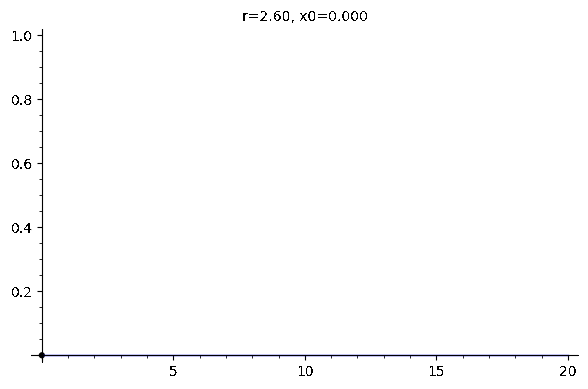

Animation with 10 frames
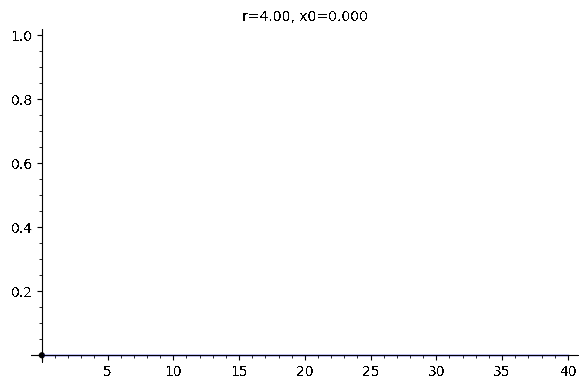

In [17]:
# Für verschiedene Startwerte

r_single_stable_point = 2.6
r_chaos = 4.0

def plot_all_starting_points(r, num_iterations=20):
    plots = []
    
    for x_start in range(0, 10):
        x_start /= 10
        # print(x_start)

        x_vals = logistic_map_iter(x_start, r, num_iterations)

        title = f"r={r.n(digits=3)}, x0={x_start.n(digits=3)}"

        plot = line(list(enumerate(x_vals)), ymin=0, ymax=1, title=title)

        plot += points([(0, x_start)], color='black', size=20)

        plots.append(plot)

    return animate(plots)

plot_all_starting_points(r_single_stable_point).show(delay = 100)
plot_all_starting_points(r_chaos, num_iterations=40).show(delay = 100)

### Beobachtung

Bis auf manche Ausnahmen wie z.B. $x_0 = 0$ und $x_0 = 1$ ist erkennbar, das für die Werte von $r$, die sich auf ein paar Punkte stabilisieren, der Startwert nicht viel Unterschied macht. Nach ein paar Iterationen werden immer die gleichen Punkte erreicht, unabhängig vom ersten Anfang. Bei den Werten von $r$ für die sich die Rekursion nicht auf ein paar Punkte stabilisiert sieht man zwar, das sich die erreichten Werte ändern, das generelle Verhalten (Chaos) ändert sich allerdings nicht.

Deswegen ist der Startwert bis auf ein paar Ausnahmen irrelevant, und wir werden im Weiteren nur den Parameter $r$ betrachten.

### Aufgabe

Was passiert beim unteren Graphen beim Startwert $x_0=0.5$? Warum passiert dies?

Lösung:

Die Iteration läuft nicht auf Chaos hinaus sondern geht erst zur 1, und bleibt dann auf der 0.
Bei $x_0=0.5$ und $r=4.0$ ist die erste Rekursion $4.0 \cdot 0.5 \cdot (1-0.5) = 1$. Danach ist der letzte Faktor 0, wodurch die Iteration immer 0 sein wird.

## Untersuchung der Häufungspunkte

Eine interessante Eigenschaft, die wir an der Iteration erkennen können, sind die Häufungspunkte. Diese wollen wir nun genauer untersuchen, hierfür wird uns das Feigenbaumdiagramm helfen. Die generelle Idee ist die, das wir für jedes $r$ (dargestellt auf der x-Achse) in einem bestimmten Bereich die jeweiligen Häufungspunkte auf der y-Achse darstellen wollen. So sehen wir nicht die gesamte Iteration, sondern nur die Punkte auf die die Iteration sich stabilisiert.

Implementiert ist dies so, das man für ein bestimmtes $r$ die Iteration `num_steps` oft ausführt, allerdings die ersten `start_offset` Werte ignoriert. Dadurch ignorieren wir die Werte, die die Iteration braucht um sich zu stabilisieren. Die restlichen Werte der Iteration werden dann jeweils als y-Wert von einem Punkt interpretiert, mit dem momentanen $r$ als x-Wert. Alle Punkte in einem Diagramm angezeigt ergibt dann das Feigenbaumdiagramm.

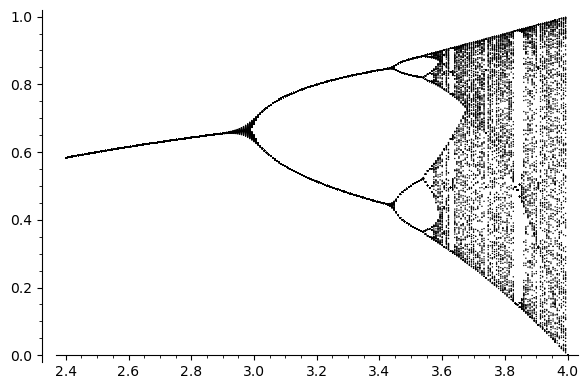

In [26]:
# actual feigenbaum diagramm
def feigenbaum_plot(r_left, r_right, step_size=150, num_steps=200, start_offset=40):
    '''
    step_size is the number of steps between each integer, points are calculated
    at each step
    '''
    plot = Graphics()

    # range from r_left to r_right, with num_steps per integer 
    for r in range(int(r_left * step_size), int(r_right * step_size) + 1):
        r /= step_size

        x_vals = logistic_map_iter(0.5, r, num_steps)
        x_vals = x_vals[start_offset:]

        plot += points([(r, x) for x in x_vals], color='black', size=1)

    plot.show(ymin=0, ymax=1, xmin=r_left, xmax=r_right)

feigenbaum_plot(r_left=2.4, r_right=4.0)

### Beobachtung

Interessant ist hier zu sehen, das die Anzahl an Häufungspunkten sich an bestimmen Werten von $r$ verdoppelt, dies nennt sich eine Bifurkation. Irgendwann gehen diese Bifurkationen in Chaos über, stabilisiert sich allerdings kurzzeitig wieder. Diese kurzzeitig stabile Phase wollen wir uns nun genauer anschauen.

## Genauere Beobachtung eines stabilen Teils des Feigenbaum-Diagrammes

Hier schauen wir uns aus dem obigen Diagramm den Ausschnitt von $r=3.81$ bis $r=3.88$ genauer an. Hier zu sehen ist, das nicht wie vorhin eine Zweierpotenz an Häufungspunkten existiert, sondern drei. Diese drei Punkte durchgehen wie vorher auch Bifurkationen, wodurch schlussendlich wieder Chaos ensteht. Tatsächlich gibt es noch unzählige weitere solcher Streifen, bei jedem ist die Anzahl der Häufungspunkte wieder eine andere.

Außerdem ist eine Iteration bei $r=3.83$ zur Veranschaulichung dargestellt.

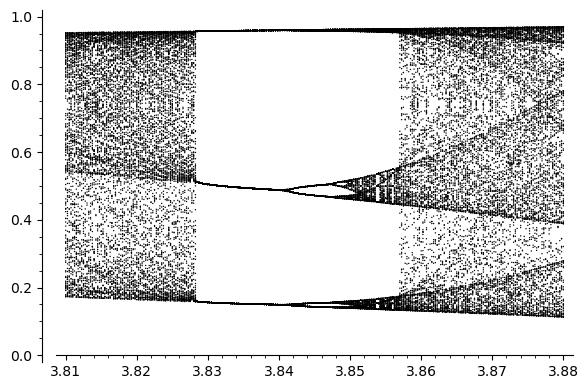

In [19]:
feigenbaum_plot(r_left=3.81, r_right=3.88, step_size=4000)

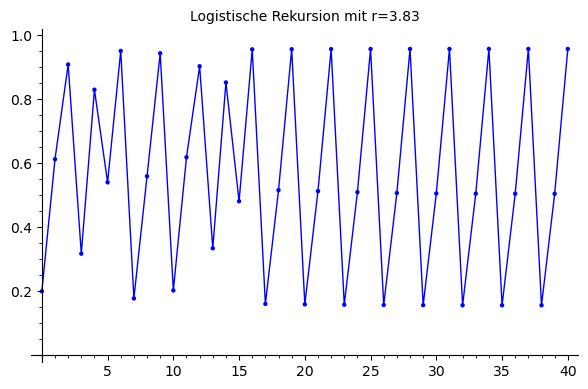

In [20]:
plot_logistic_map_iter(0.2, 3.83, 40)

## Feigenbaum-Diagramm außerhalb von $r \in [2.4, 4.0]$

Bisher haben wir uns nur das Feigenbaum-Diagramm im Intervall von $2.4$ und $4.0$ angeschaut, weil dies die interessanteste Region ist. Hier wollen wir uns kurz die Region vor und die Region hinter diesem Intervall anschauen.

## Region $r > 4$

Für $r$ größer als 4 bleiben die erreichten Wert nicht im Intervall $[0,1]$, sondern explodieren sehr schnell ins Unendliche.

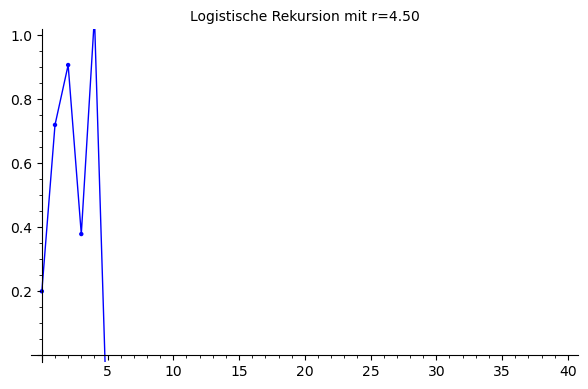

x-Werte: [0.200, 0.720, 0.907, 0.379, 1.06, -0.281, -1.62, -19.1, -1720., -1.34e7, -8.07e14, -2.93e30, -3.87e61, -6.74e123, -2.04e248, -1.88e497, -1.59e995, -1.14e1991, -5.86e3982, -1.54e7966, -1.07e15933, -5.18e31866, -1.21e63734, -6.56e127468, -1.93e254938, -1.68e509877, -1.27e1019755, -7.30e2039510, -2.40e4079022, -2.59e8158045, -3.01e16316091, -4.09e32632183, -7.51e65264367, -2.54e130528736, -2.90e261057473, -3.80e522114947, -6.49e1044229895, -1.89e2088459792, -1.61e4176919585, -1.17e8353839171, -6.19e16707678342]


In [34]:
plot_logistic_map_iter(0.2, 4.5, 40)

x_vals = logistic_map_iter(0.2, 4.5, 40)
print(f"x-Werte: {[x.n(digits=3) for x in x_vals]}")

## $r \in [0, 4]$

Hier ist zu sehen das die Iteration für $r$ kleiner 1 zur 0 tendiert, und erst dann zu einem anderen Wert.

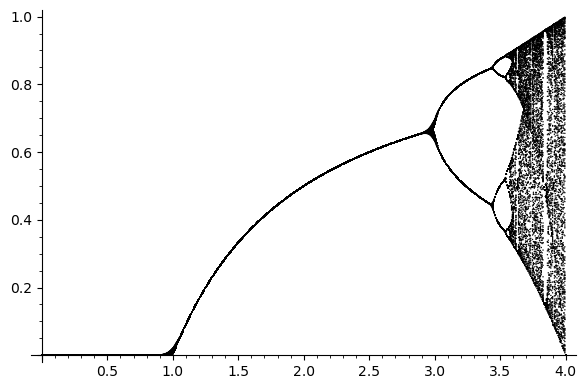

In [27]:
feigenbaum_plot(r_left=0, r_right=4)